<a href="https://colab.research.google.com/github/JMSBornot/PytorchCourseDL/blob/main/simple_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read MNIS images data into Tensors
ttfunc = transforms.ToTensor() # transform to tensor function
train_data = datasets.MNIST(root='input_data', train=True, download=True, transform=ttfunc)
test_data = datasets.MNIST(root='input_data', train=False, download=True, transform=ttfunc)
print(train_data)
print(test_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8906597.31it/s] 


Extracting input_data/MNIST/raw/train-images-idx3-ubyte.gz to input_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1619634.37it/s]


Extracting input_data/MNIST/raw/train-labels-idx1-ubyte.gz to input_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13615621.19it/s]


Extracting input_data/MNIST/raw/t10k-images-idx3-ubyte.gz to input_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2644070.61it/s]

Extracting input_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input_data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: input_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: input_data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
# Create CNN model
cnv1 = nn.Conv2d(1, 6, 3, 1) # 1 indicates 1 image as input, 6 for channels/filters, 3x3 for kernel size, and stride=1 in this order
cnv2 = nn.Conv2d(6, 16, 3, 1) # input are the 6 channels/filters from cnv1, and it uses 16 channels/filters with 3x3 kernel

In [4]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
  break
X_train.shape
x = X_train.view(1,1,28,28) # reshape the tensor
print(x.shape)

torch.Size([1, 1, 28, 28])


In [5]:
# Perform the first convolution operation
x = F.relu(cnv1(x))
print(x.shape)
# Pass through the pooling layer
x = F.max_pool2d(x,2,2)
print(x.shape)
# Second convolution operation
x = F.relu(cnv2(x))
print(x.shape)
# Pass through the pooling layer
x = F.max_pool2d(x,2,2)
print(x.shape)

torch.Size([1, 6, 26, 26])
torch.Size([1, 6, 13, 13])
torch.Size([1, 16, 11, 11])
torch.Size([1, 16, 5, 5])


In [6]:
# Model class
class CANN(nn.Module):
  def __init__(self):
    super().__init__() # always first instantiate the ancestor class
    # covolution layers separated by pooling layers
    self.cnv1 = nn.Conv2d(1,6,3,1)	# input 1x1x28x28 -> 1x6x26x26
    self.cnv2 = nn.Conv2d(6,16,3,1)	# input 1x6x13x13 -> 1x16x11x11 (between cnv1 and cnv2 layers, there is a dropout layer reducing the size 50%)
    # fully connected layers stacked at the end, receiving flattened convolution outcome
    self.fc1 = nn.Linear(16*5*5,120)	# input 1x16x5x5 -> 1x120 (between cnv2 and fc1 layers, there is a dropout layer reducing the size 50%)
    self.fc2 = nn.Linear(120,84)	# input 1x120 -> 1x84
    self.fc3 = nn.Linear(84,10)		# input 1x84 -> 1x10

  def forward(self, x):
    # Convolution layers processing
    x = F.relu(self.cnv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.cnv2(x))
    x = F.max_pool2d(x,2,2)

    # flatten conv layers output
    x = x.view(-1,16*5*5) # treating the first dimension as unknown (-1) so we can vary the batch size

    # Fully connected layers processing
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x,dim=1)

In [7]:
# Create and instance and use the model
torch.manual_seed(41)
model = CANN()
model

CANN(
  (cnv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (cnv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
# Loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [10]:
import time

# Control variables
Ne = 10                # Number of epochs
Nb = 20               # Batch size
trainLoss = []
testLoss = []
trainAcc = []
testAcc = []

train_loader = DataLoader(train_data, batch_size=Nb, shuffle=True)
test_loader = DataLoader(test_data, batch_size=Nb, shuffle=False)

Ntr = train_loader.dataset.train_data.size(0)
Nte = test_loader.dataset.test_data.size(0)

### Training CNN model
T0 = time.time()

for i in range(Ne): # epochs loop
  acc_train = 0
  acc_test = 0
  num = 0

  # Evaluate for each batch's samples
  for j, (Xtr, ytr) in enumerate(train_loader):
    # Propagate forward and calculate the loss
    out = model(Xtr)  # not flattenet: dim is Nb x 10
    loss = criterion(out, ytr)

    # Accumulate classification accuracy
    _, ind = torch.max(out.data, 1, keepdim=True) # ind's dimension is Nb x 1. If only one output argument is specified then the output will be a tuple (max_value, ind)
    acc_train += (ytr.reshape(-1,1) == ind.reshape(-1,1)).sum()

    # Update CNN model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Learning feedback
    if (j+1) % 500 == 0: # it runs for 3000 iterations: 3000 x (20 batch samples) = 60,000 MNIST images
      print(f"Epoch {i+1}, Batch {j+1}: Loss = {loss.data}")

  trainLoss.append(loss)
  trainAcc.append(acc_train)

  # Evaluation on test data
  with torch.no_grad(): # switch off gradient calculation for efficiency
    for j, (Xte, yte) in enumerate(test_loader):
      out = model(Xte)
      _, ind = torch.max(out.data, 1, keepdim=True)
      acc_test += (yte.reshape(-1,1) == ind.reshape(-1,1)).sum()

  loss = criterion(out, yte)
  testLoss.append(loss)
  testAcc.append(acc_test)

  print(f"Epoch {i+1}, Train_Loss = {trainLoss[-1]}, Test_Loss = {testLoss[-1]}, Train_Acc = {trainAcc[-1]/Ntr}, Test_Acc = {testAcc[-1]/Nte}")

total =  time.time() - T0
print(f"Training took: {total/60} minutes!")

Epoch 1, Batch 500: Loss = 0.00036072140210308135
Epoch 1, Batch 1000: Loss = 2.276878603879595e-06
Epoch 1, Batch 1500: Loss = 5.0341459427727386e-05
Epoch 1, Batch 2000: Loss = 9.216192120220512e-05
Epoch 1, Batch 2500: Loss = 0.0003438266576267779
Epoch 1, Batch 3000: Loss = 0.0009741733665578067
Epoch 1, Train_Loss = 0.0009741733665578067, Test_Loss = 0.0544222816824913, Train_Acc = 0.9954500198364258, Test_Acc = 0.9887999892234802
Epoch 2, Batch 500: Loss = 0.0002837936917785555
Epoch 2, Batch 1000: Loss = 5.931327541475184e-05
Epoch 2, Batch 1500: Loss = 3.445115680733579e-06
Epoch 2, Batch 2000: Loss = 0.00823075883090496
Epoch 2, Batch 2500: Loss = 0.00010210071923211217
Epoch 2, Batch 3000: Loss = 0.00016595258784946054
Epoch 2, Train_Loss = 0.00016595258784946054, Test_Loss = 0.0002810130245052278, Train_Acc = 0.996566653251648, Test_Acc = 0.988099992275238
Epoch 3, Batch 500: Loss = 0.0006606925162486732
Epoch 3, Batch 1000: Loss = 0.00013165624113753438
Epoch 3, Batch 1500:

Text(0, 0.5, 'Loss/Error')

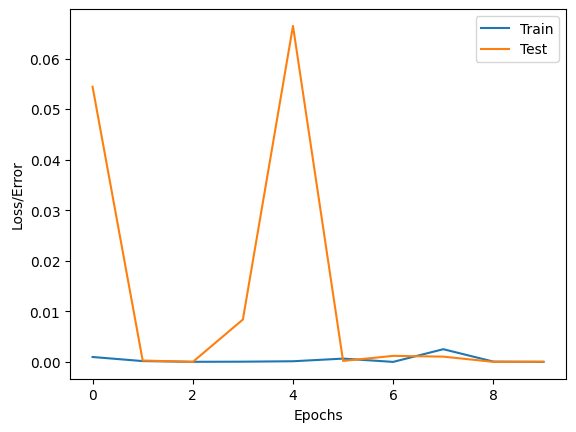

In [15]:
plt.plot([x.data for x in trainLoss], label="Train")
plt.plot(testLoss, label="Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')

Text(0, 0.5, 'Accuracy')

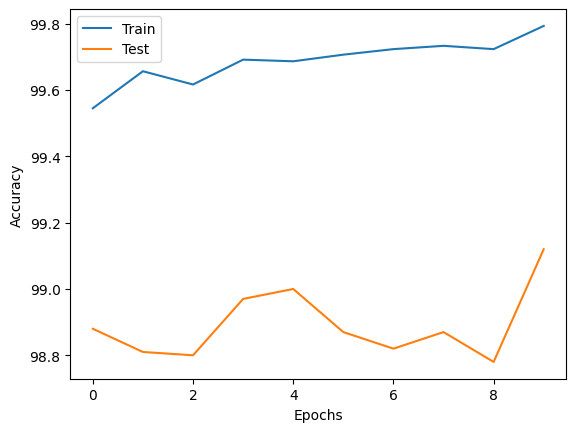

In [20]:
plt.plot([100*x/Ntr for x in trainAcc], label="Train")
plt.plot([100*x/Nte for x in testAcc], label="Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [22]:
# Evaluate the entire test data after for the trained model
test_alldata = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
  acc = 0
  for Xte, yte in test_alldata:
    out = model(Xte)
    _, ind = torch.max(out.data, 1, keepdim=True)
    acc += (yte.reshape(-1,1) == ind.reshape(-1,1)).sum()

print(f"Accuracy for test data: {acc/Nte}")

Accuracy for test data: 0.9911999702453613


Text(0.5, 1.0, '9')

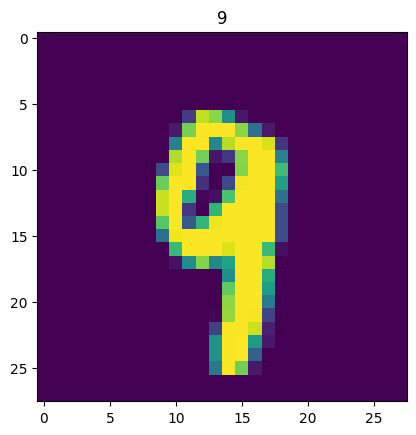

In [29]:
ind = 4143
plt.imshow(test_data[ind][0].reshape(28,28))
plt.title(test_data[ind][1])

In [30]:
# Evaluate a single image with the CNN model
model.eval()
with torch.no_grad():
  out = model(test_data[ind][0].reshape(1,1,28,28)) # batch size of 1, 1 color channel, and 28x28 pixels image
  print(out.argmax())

tensor(9)
